In [1]:
%cd ../
## Autorreload all the files
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
from src.spline import *

print("Device cuda: ", torch.cuda.is_available())

c:\Users\SUNNY\projects\MonoKAN
Device cuda:  True


In [2]:
in_dim, out_dim = 3,2
num=5
k=3
bs = 100

x = torch.rand(bs, in_dim)
y = torch.rand(bs, out_dim)

grid = extend_grid(torch.linspace(-1, 1, num+1).repeat(in_dim, 1), k_extend=k)
print("Grid shape: ", grid.shape)

noises = (torch.rand(num+1, in_dim, out_dim) - 1/2) * .5 / num
coef = curve2coef(grid[:, k:-k].permute(1, 0), noises, grid, k)
scale_sp = torch.ones(in_dim, out_dim) / np.sqrt(in_dim)

scale_base = (torch.rand(in_dim, out_dim) * 2-1)/np.sqrt(in_dim)
print("Scale base shape: ", scale_base.shape)
base_fun=nn.SiLU()

# scale_base = torch.zeros(in_dim, out_dim)
# base_fun=nn.Identity()



Grid shape:  torch.Size([3, 12])
Scale base shape:  torch.Size([3, 2])


In [ ]:
import torch
in_dim, out_dim = 10, 3

in_coord = torch.arange(in_dim) * 1/in_dim + 1/(2*in_dim)
out_coord = torch.arange(out_dim) * 1/out_dim + 1/(2*out_dim)

# print(in_coord, out_coord)

dist_mat = torch.abs(out_coord[:,None] - in_coord[None,:])
# print(dist_mat)

in_nearest = torch.argmin(dist_mat, dim=0)
in_connection = torch.stack([torch.arange(in_dim), in_nearest]).permute(1,0)
out_nearest = torch.argmin(dist_mat, dim=1)
out_connection = torch.stack([out_nearest, torch.arange(out_dim)]).permute(1,0)
all_connection = torch.cat([in_connection, out_connection], dim=0)
mask = torch.zeros(in_dim, out_dim)
mask[all_connection[:,0], all_connection[:,1]] = 1.
mask

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [34]:
in_dim, out_dim = 9, 3

in_coord = (torch.arange(in_dim) + 0.5) / in_dim
out_coord = (torch.arange(out_dim) + 0.5) / out_dim

in_to_out = torch.argmin(torch.abs(out_coord[None, :] - in_coord[:, None]), dim=1)
out_to_in = torch.argmin(torch.abs(in_coord[None, :] - out_coord[:, None]), dim=1)

mask = torch.zeros(in_dim, out_dim)
mask[torch.arange(in_dim), in_to_out] = 1.0
mask[out_to_in, torch.arange(out_dim)] = 1.0
mask

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [5]:
bs = x.shape[0]
preacts = x[:, None, :].clone().expand(bs, out_dim, in_dim)
y = coef2curve(x, grid, coef, k)  # bs, in_dim, out_dim

postspline = y.clone().permute(0,2,1)  # bs, out_dim, in_dim
base = base_fun(x)

y = scale_base[None, :, :] * base[:, :, None] + scale_sp[None, :, :] * y

postacts = y.clone().permute(0,2,1)  # bs, out_dim, in_dim

y = torch.sum(y, dim=1)  # bs, in_dim
y.shape

torch.Size([100, 2])

checkpoint directory created: ./model
saving model version 0.0
torch.Size([1000, 9]) torch.Size([1000, 3])


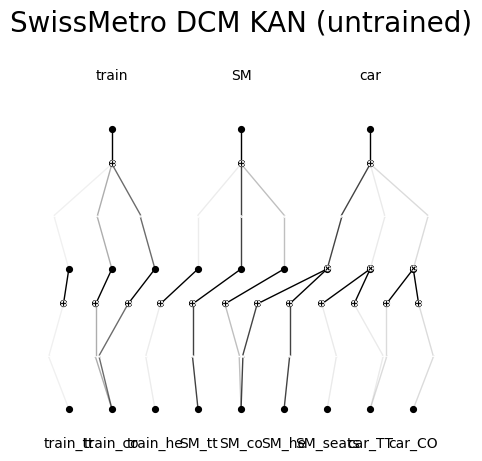

In [3]:
import torch
import numpy as np

# import matplotlib
# matplotlib.use("QT5Agg")  # 使用Qt5后端
import matplotlib.pyplot as plt

from kan import KAN


def create_dcm_swissmetro_dataset(
    train_num=1000,
    test_num=1000,
    ranges=[-2, 2],  # 比如特征范围设宽一点
    noise_std=0.1,  # 噪声强度
    normalize_input=False,
    normalize_label=False,
    device="cpu",
    seed=0,
):
    """
    生成SwissMetro DCM三备选 synthetic 数据集，含线性项和交互项

    Args:
    -----
        train_num : int
            训练样本数
        test_num : int
            测试样本数
        ranges : list, (2,) or (n_var, 2)
            特征范围（每个特征的min,max），支持统一/分特征
        noise_std : float
            效用扰动高斯噪声标准差
        normalize_input : bool
            是否归一化输入
        normalize_label : bool
            是否归一化输出
        device : str
            设备
        seed : int
            随机种子

    Returns:
    -------
        dataset : dict
            'train_input':  (train_num, 9)
            'test_input':   (test_num, 9)
            'train_label':  (train_num, 3)
            'test_label':   (test_num, 3)
    """

    np.random.seed(seed)
    torch.manual_seed(seed)
    n_var = 9

    # 统一范围/分特征范围
    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)

    def sample_input(num):
        x = torch.zeros(num, n_var)
        for i in range(n_var):
            x[:, i] = torch.rand(num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        return x

    train_input = sample_input(train_num)
    test_input = sample_input(test_num)

    # 别名: x[0~2] = train, x[3~6] = SM, x[7~8] = car
    def utility_func(x):
        # x: [batch, 9]
        # beta, gamma: 任意设置，可微调
        # train
        u_train = (
            -2.0 * x[:, 0]  # train_tt
            - 1.5 * x[:, 1]  # train_co
            - 0.5 * x[:, 2]  # train_he
            + 1.0 * x[:, 0] * x[:, 2]  # interaction: train_tt * train_he
        )
        # SM
        u_sm = (
            -2.2 * x[:, 3]  # SM_tt
            - 1.4 * x[:, 4]  # SM_co
            - 0.8 * x[:, 5]  # SM_he
            + 1.2 * x[:, 3] * x[:, 5]  # interaction: SM_tt * SM_he
            + 0.6 * x[:, 6]  # SM_seats
        )
        # car
        u_car = (
            -1.8 * x[:, 7]  # car_TT
            - 2.1 * x[:, 8]  # car_CO
            + 0.7 * x[:, 7] * x[:, 8]  # interaction: car_TT * car_CO
        )
        # 叠加高斯噪声
        batch = x.shape[0]
        noise = noise_std * torch.randn(batch, 3)
        return torch.stack([u_train, u_sm, u_car], dim=1) + noise

    train_label = utility_func(train_input)
    test_label = utility_func(test_input)

    def normalize(data, mean, std):
        return (data - mean) / std

    if normalize_input:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
    if normalize_label:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = dict(
        train_input=train_input.to(device),
        test_input=test_input.to(device),
        train_label=train_label.to(device),
        test_label=test_label.to(device),
    )
    return dataset


def test_multikan():

    width = [
        [9, 0],  # 9 input features
        [6, 3],  # 6 sum nodes, 3 mult nodes (for 3 pairwise interactions)
        [3, 0],  # 3 outputs (utility for each alternative)
    ]
    mult_arity = [
        [],  # input layer: no mult node
        [2, 2, 2],  # each mult node does two-way interaction
        [],  # output layer
    ]
    kan = KAN(width, mult_arity=2, device="cuda", sparse_init=True)

    dataset = create_dcm_swissmetro_dataset(
        train_num=1000, test_num=1000, device="cuda"
    )
    print(dataset["train_input"].shape, dataset["train_label"].shape)
    kan(dataset["train_input"])
    kan.plot(
        in_vars=[
            "train_tt",
            "train_co",
            "train_he",
            "SM_tt",
            "SM_co",
            "SM_he",
            "SM_seats",
            "car_TT",
            "car_CO",
        ],
        out_vars=["train", "SM", "car"],
        title="SwissMetro DCM KAN (untrained)",
        varscale=0.5,
    )
    # plt.show()

    # 训练KAN模型
    # kan.fit(
    #     dataset,
    #     opt="LBFGS",
    #     steps=20,
    #     lamb=0.01,
    #     in_vars=[
    #         "train_tt",
    #         "train_co",
    #         "train_he",
    #         "SM_tt",
    #         "SM_co",
    #         "SM_he",
    #         "SM_seats",
    #         "car_TT",
    #         "car_CO",
    #     ],
    #     out_vars=["train", "SM", "car"],
    #     save_fig=True
    # )
    # kan.plot(
    #     in_vars=[
    #         "train_tt",
    #         "train_co",
    #         "train_he",
    #         "SM_tt",
    #         "SM_co",
    #         "SM_he",
    #         "SM_seats",
    #         "car_TT",
    #         "car_CO",
    #     ],
    #     out_vars=["train", "SM", "car"],
    #     title="SwissMetro DCM KAN (trained)",
    # )
    # plt.show()
    return


if __name__ == "__main__":
    test_multikan()
    # print("Test completed successfully.")

In [2]:
from src.KANLayer import *

in_dim, out_dim = 2, 4
bs=3

kan_layer = KANLayer(in_dim=in_dim, out_dim=out_dim, num=5, k=3, include_basis=True, sparse_init=True, grid_range=[-1, 1], device="cuda")
x = torch.rand(bs, in_dim).to("cuda")
y, preacts, postacts, postspline = kan_layer(x)
y.shape

torch.Size([3, 4])

In [7]:
print("postacts", postacts)
print("postspline", postspline)
print("masks", kan_layer.mask)
print("basis", (kan_layer.scale_base[None, :, :] * kan_layer.base_fun(x)[:, :, None]).permute(0,2,1))
print("output", y)

postacts tensor([[[-0.0460,  0.0000],
         [-0.2987, -0.0000],
         [-0.0000, -0.2111],
         [ 0.0000,  0.1169]],

        [[ 0.0115,  0.0000],
         [-0.0235, -0.0000],
         [-0.0000, -0.0055],
         [ 0.0000,  0.0033]],

        [[ 0.0112,  0.0000],
         [-0.0239, -0.0000],
         [-0.0000, -0.0402],
         [ 0.0000,  0.0260]]], device='cuda:0', grad_fn=<PermuteBackward0>)
postspline tensor([[[ 0.0117, -0.0482],
         [ 0.0170,  0.0107],
         [ 0.0141, -0.0305],
         [-0.0433, -0.0179]],

        [[ 0.0280,  0.0414],
         [ 0.0340, -0.0436],
         [-0.0055,  0.0373],
         [ 0.0481, -0.0262]],

        [[ 0.0278,  0.0211],
         [ 0.0341, -0.0424],
         [-0.0056,  0.0362],
         [ 0.0481, -0.0269]]], device='cuda:0', grad_fn=<PermuteBackward0>)
masks Parameter containing:
tensor([[1., 1., 0., 0.],
        [0., 0., 1., 1.]], device='cuda:0')
basis tensor([[[-0.0543,  0.2453],
         [-0.3107, -0.1494],
         [-0.1872, -

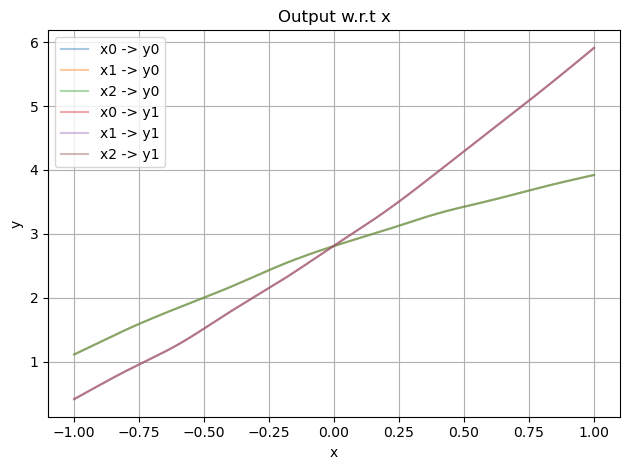

In [12]:
from src.KANLayer import KANLayer
kan = KANLayer(in_dim=3, out_dim=2, num=10, k=3, monotonic_dims_dirs=[(0, 1)], include_basis=True, )
with torch.no_grad():
    x_test = torch.linspace(-1, 1, 10000).unsqueeze(1).repeat(1, kan.in_dim)  # shape (100, in_dim)
    y_test, *_ = kan(x_test)
    import matplotlib.pyplot as plt
    plt.plot(x_test[:, 0], y_test[:, 0], alpha=0.4, label="x0 -> y0")  # 如果是单调模型应该是递增曲线
    plt.plot(x_test[:, 1], y_test[:, 0], alpha=0.4, label="x1 -> y0")  # 如果是单调模型应该是递增曲线
    plt.plot(x_test[:, 2], y_test[:, 0], alpha=0.4, label="x2 -> y0")  # 如果是单调模型应该是递增曲线
    plt.plot(x_test[:, 0], y_test[:, 1], alpha=0.4, label="x0 -> y1")  # 第二个输出
    plt.plot(x_test[:, 1], y_test[:, 1], alpha=0.4, label="x1 -> y1")  # 第二个输出
    plt.plot(x_test[:, 2], y_test[:, 1], alpha=0.4, label="x2 -> y1")  # 第二个输出    
    
    plt.title("Output w.r.t x")
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


Epoch   0: Loss = 32.605015
Epoch  20: Loss = 16.614422
Epoch  40: Loss = 7.868414
Epoch  60: Loss = 3.456865
Epoch  80: Loss = 1.497476
Epoch 100: Loss = 0.788759
Epoch 120: Loss = 0.546706
Epoch 140: Loss = 0.433747
Epoch 160: Loss = 0.363886
Epoch 180: Loss = 0.314659
Epoch 199: Loss = 0.276963


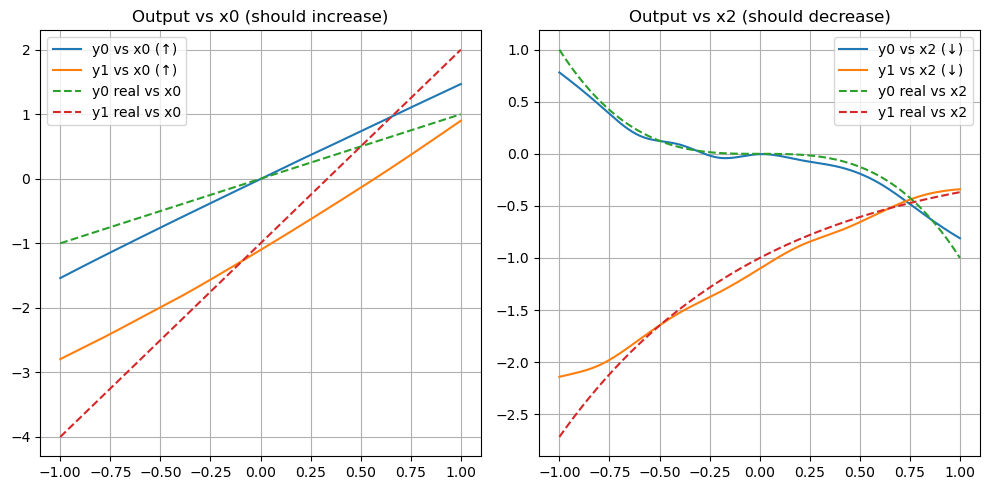

In [54]:
import torch
import torch.nn as nn
from src.KANLayer import KANLayer
import matplotlib.pyplot as plt

# === 构造 ground truth 函数 ===
def true_func(x):  # x: (N, 3)
    x0, x1, x2 = x[:, 0], x[:, 1], x[:, 2]
    y0 = x0 + torch.sin(x1) - x2**3          # y0: x0 ↑, x2 ↓
    y1 = 3 * x0 - torch.exp(-x2)             # y1: x0 ↑, x2 ↓
    return torch.stack([y0, y1], dim=1)      # (N, 2)

# === 构造训练数据 ===
torch.manual_seed(42)
N = 10000
x_train = torch.rand(N, 3) * 2 - 1  # uniform(-1, 1)
y_train = true_func(x_train)

# === 初始化模型 ===
model = KANLayer(
    in_dim=3, out_dim=2, num=10, k=3,
    # monotonic_dims_dirs=[(0, 1), (2, -1)],  # x0 ↑, x2 ↓
    monotonic_dims_dirs=[(0, 1)],  # x0 ↑, x2 ↓
    include_basis=True
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

# === 训练过程 ===
for epoch in range(200):
    model.train()
    y_pred, *_ = model(x_train)
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 199:
        print(f"Epoch {epoch:3d}: Loss = {loss.item():.6f}")

# === 可视化输出随 x0 / x2 变化趋势 ===
x_plot = torch.linspace(-1, 1, 1000)

with torch.no_grad():
    x_probe = torch.zeros(1000, 3)
    x_probe[:, 0] = x_plot  # vary x0
    y_pred_x0, *_ = model(x_probe)
    y_real_x0 = true_func(x_probe)

    x_probe = torch.zeros(1000, 3)
    x_probe[:, 2] = x_plot  # vary x2
    y_pred_x2, *_ = model(x_probe)
    y_real_x2 = true_func(x_probe)

# === Plot ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_pred_x0[:, 0], label="y0 vs x0 (↑)")
plt.plot(x_plot, y_pred_x0[:, 1], label="y1 vs x0 (↑)")
plt.plot(x_plot, y_real_x0[:, 0], '--', label="y0 real vs x0")
plt.plot(x_plot, y_real_x0[:, 1], '--', label="y1 real vs x0")
plt.title("Output vs x0 (should increase)")
plt.grid(True); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_plot, y_pred_x2[:, 0], label="y0 vs x2 (↓)")
plt.plot(x_plot, y_pred_x2[:, 1], label="y1 vs x2 (↓)")
plt.plot(x_plot, y_real_x2[:, 0], '--', label="y0 real vs x2")
plt.plot(x_plot, y_real_x2[:, 1], '--', label="y1 real vs x2")
plt.title("Output vs x2 (should decrease)")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()
